In [1]:
#!/usr/bin/env python
# coding: utf-8

In[25]:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import *
get_ipython().run_line_magic('matplotlib', 'inline')
mm=10**-3

## Bowtie Cavity Geometry

Mirrors on hand:<br>
<br>
laytec \#110668 : 75mm RoC, HR(0Â°,710-890nm)>99.95% + R(0Â°,350-450nm)<5%,  	AR(0Â°,350-450nm)<0.2%<br>
<br>


A bowtie cavity has three independant geometric parameters: the short arm length $d_1$, long arm length $d_2$, and folding angle $\alpha$.

In[26]:

In [80]:
def cos_ang(a,b,c):
    return (a**2+b**2 -c**2)/2/a/b

In [83]:
ang = cos_ang(11.5,13.8,5.5)*180/np.pi

In [84]:
ang

52.79010006555072

In [107]:
d_1=115.*mm#physical seperation of mirror in short arm, not optical path length
d_2=135.*mm
alpha=(90 - ang)*np.pi/180/2

In [108]:
alpha*(180/np.pi)

18.60494996722464

In [109]:
R=100.*mm #mirror RoC
lam=1087E-9 #wavelength of fundamental

Include extra optical path length of crystal in the short arm:

In[27]:

In [110]:
l_c=20*mm #crystal length
n_c=1.66 #approximate refractive index
d_short=(d_1-l_c)+l_c/(n_c)#effective optical path length in short arm %why l_c / n_c 
print(d_short/mm)

107.04819277108433


# Brewster angle and refraction angle:

In[28]:

In [111]:
thetaB = arctan(n_c)
print('brewster:',thetaB*180./pi)
thetaR = arcsin(sin(thetaB)/n_c)
print('refraction angle:',thetaR*180./pi)
print((d_1-l_c)/2.*1e3)

brewster: 58.93483511450135
refraction angle: 31.065164885498643
47.5


Plot cavity approximate geometry (without brewster displacement) including a 15mm $\times$ 15mm oven:

In[29]:

long flat length: 135.0000 mm
width: 42.0792 mm


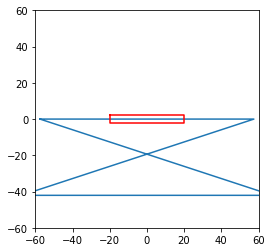

In [115]:
# l_3=(d_2-d_1/np.cos(alpha))/(1+1/np.cos(alpha))#length of long parallel segment
l_3 = d_2
print('long flat length: %0.4f mm'%(l_3/mm))
width=d_1/2.*np.tan(alpha)+l_3/2.*np.tan(alpha)
print('width: %0.4f mm'%(width/mm))
A=np.array([-d_1/2.,0])
B=np.array([d_1/2.,0])
C=np.array([-l_3/2.,-width])
D=np.array([l_3/2.,-width])
XY=np.vstack((A,B,C,D,A))
fig = plt.figure(figsize=(4, 4)) #make plot square for true aspect ratio
plt.plot(XY[:,0]/mm,XY[:,1]/mm)
scale=60#half window size in mm
plt.xlim(-scale,scale)
plt.ylim(-scale,scale)
ovendim=40*mm
A=np.array([-ovendim/2,ovendim2/2])
B=np.array([ovendim/2,ovendim2/2])
C=np.array([ovendim/2,-ovendim2/2])
D=np.array([-ovendim/2,-ovendim2/2])
XY=np.vstack((A,B,C,D,A))
plt.plot(XY[:,0]/mm,XY[:,1]/mm,'r')

## Find waists by ABCD matrices:

Define matrices for propegation and focusing from spherical mirrors (both horizontal and vertical):

In[12]:

In [116]:
def prop(x): #x is propegation distance
    out=np.array([[1,x],[0,1]])
    out=np.mat(out)#cast as matrix for easier multiplication
    return out

In [117]:
def horzf(R,alpha): #R is radius of curvature for spherical mirror(R = 2f), and alpha is the folding angle in rad
    out=np.array([[1,0],[-2/(R*np.cos(alpha)),1]])
    out=np.mat(out) #cast as matrix for easier multiplication
    return out

In [118]:
def vertf(R,alpha): #R is radius of curvature for spherical mirror, and alpha is the folding angle in rad
    out=np.array([[1,0],[-2*cos(alpha)/R,1]])
    out=np.mat(out)#cast as matrix for easier multiplication
    return out

In [119]:
def crys_in(nc): #nc is crystal index
    out=np.array([[nc,0],[0,1/nc]])
    out=np.mat(out)#cast as matrix for easier multiplication
    return out

In [120]:
def crys_out(nc): #nc is crystal index
    out=np.array([[1/nc,0],[0,nc]])
    out=np.mat(out)#cast as matrix for easier multiplication
    return out

Find $M$ matrices for both horinzontal and vertical directions at the crystal focus:

In[30]:

In [121]:
def M_h_crys(d_1,d_2,alpha):
    #round trip martix at crystal,d_1 is physical speration of short arm, d_2 long arm
    d_x = (d_1-l_c)/2.
    return prop(l_c/2./n_c)*crys_out(n_c)*prop(d_x)*horzf(R,alpha)*prop(d_2)*horzf(R,alpha)*prop(d_x)*crys_in(n_c)*prop(l_c/2./n_c)

In [122]:
def M_v_crys(d_1,d_2,alpha):
    #round trip martix at crystal,d_1 is physical speration of short arm, d_2 long arm
    d_x = (d_1-l_c)/2.
    return prop(l_c/2./n_c)*prop(d_x)*vertf(R,alpha)*prop(d_2)*vertf(R,alpha)*prop(d_x)*prop(l_c/2./n_c)

In [123]:
M_h=M_h_crys(d_1,d_2,alpha)
M_v=M_v_crys(d_1,d_2,alpha)

Check the stability condition $\left|\frac{A+D}{2}\right|<1 \quad$    for both directions

In[31]:

In [124]:
def g(M):
    out=(M[0,0]+M[1,1])/2
    return out
print(g(M_h))
print(g(M_v))

-0.7006081116632668
-0.9918738955942936


Find waists at crystal focus:

In[32]:

In [125]:
def waist(M): #M is round trip matrix
    out=np.sqrt(-lam*M[0,1]/(np.pi*np.sqrt(1-g(M)**2)))
    return out

In [126]:
print('Horizontal waist: %.1f microns'%(waist(M_h)*1e6))
print('Vertical waist: %.1f microns'%(waist(M_v)*1e6))

Horizontal waist: 70.7 microns
Vertical waist: 64.5 microns


In [127]:
a = np.pi*0.02*0.02/(7.01*1e-4)
b = a * np.sqrt((1/0.02**2)-1)
print(a)
print(b)

1.7926348950583701
89.61381661097441


Find waists for long arm:

In[33]:

In [73]:
def M_h_long(d_1,d_2,alpha):
    #round trip martix at long arm,d_1 is physical speration of short arm, d_2 long arm
    d_x = (d_1-l_c)/2.
    return prop(d_2/2.)*horzf(R,alpha)*prop(d_x)*crys_in(n_c)*prop(l_c/n_c)*crys_out(n_c)*prop(d_x)*horzf(R,alpha)*prop(d_2/2.)

In [74]:
def M_v_long(d_1,d_2,alpha):
    #round trip martix at long arm,d_1 is physical speration of short arm, d_2 long arm
    d_x = (d_1-l_c)/2.
    return prop(d_2/2.)*vertf(R,alpha)*prop(d_x)*prop(l_c/n_c)*prop(d_x)*vertf(R,alpha)*prop(d_2/2.)

In [75]:
M_h2=prop(d_2/2.)*horzf(R,alpha)*prop(d_short)*horzf(R,alpha)*prop(d_2/2.)
M_v2=prop(d_2/2.)*vertf(R,alpha)*prop(d_short)*vertf(R,alpha)*prop(d_2/2.)
print('Horizontal waist: %.1f microns'%(waist(M_h2)*1e6),',no crsytal')
print('Vertical waist: %.1f microns'%(waist(M_v2)*1e6),',no crystal')

Horizontal waist: 154.0 microns ,no crsytal
Vertical waist: nan microns ,no crystal


C:\Users\Jianhui\AppData\Local\Temp\ipykernel_12380\936263719.py:2: RuntimeWarning: invalid value encountered in sqrt
  out=np.sqrt(-lam*M[0,1]/(np.pi*np.sqrt(1-g(M)**2)))


Plot Waists over range of short arm lengths

In[34]:

In [78]:
d1a=np.linspace(110,115,100)*mm
wh1=np.zeros(len(d1a))
wv1=np.zeros(len(d1a))
wh2=np.zeros(len(d1a))
wv2=np.zeros(len(d1a))
for i in range(len(d1a)):
    wh1[i]=waist(M_h_crys(d1a[i],d_2,alpha))*1e6
    wv1[i]=waist(M_v_crys(d1a[i],d_2,alpha))*1e6
    wh2[i]=waist(M_h_long(d1a[i],d_2,alpha))*1e6
    wv2[i]=waist(M_v_long(d1a[i],d_2,alpha))*1e6

C:\Users\Jianhui\AppData\Local\Temp\ipykernel_12380\936263719.py:2: RuntimeWarning: invalid value encountered in sqrt
  out=np.sqrt(-lam*M[0,1]/(np.pi*np.sqrt(1-g(M)**2)))


In[35]:

(0.0, 500.0)

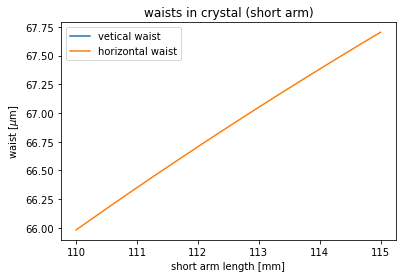

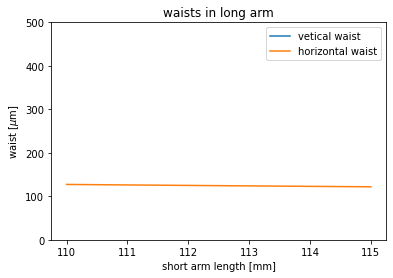

In [79]:
fig2 = plt.figure()
plt.plot(d1a/mm,wv1,label='vetical waist')
plt.plot(d1a/mm,wh1,label='horizontal waist')
plt.xlabel('short arm length [mm]')
plt.ylabel(r'waist [$\mu$m]')
plt.title('waists in crystal (short arm)')
plt.legend(loc=2)
fig3 = plt.figure()
plt.plot(d1a/mm,wv2,label='vetical waist')
plt.plot(d1a/mm,wh2,label='horizontal waist')
plt.xlabel('short arm length [mm]')
plt.ylabel(r'waist [$\mu$m]')
plt.title('waists in long arm')
plt.legend(loc=1)
plt.ylim(0,500)

In[ ]:

In[ ]:

In[ ]: